# Подключение библиотеки

In [1]:
import os
import pathlib
import librosa
from datasets import load_dataset, load_from_disk

import random
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import tensorflow as tf
from sklearn.preprocessing import LabelEncoder

from tensorflow.keras import layers
from tensorflow.keras import models
# from IPython.display import display, Audio 
from IPython import display

# Set the seed value for experiment reproducibility.
seed = 42
tf.random.set_seed(seed)
np.random.seed(seed)

2024-03-03 15:26:18.661979: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-03-03 15:26:18.662179: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-03-03 15:26:18.841588: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-03-03 15:26:19.217064: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-03-03 15:26:20.654788: W tensorflow/compiler/tf2

## Загрузка датасет

In [2]:
data_dir = '/home/redalexdad/recognition_speech/RUSLAN'
metadata_path = '/home/redalexdad/recognition_speech/RUSLAN/metadata_RUSLAN_22200.csv'

In [3]:
# Загрузка метаданных
metadata = pd.read_csv(metadata_path, names=['ID', 'Text'], delimiter='|', encoding='utf-8')

# Создание LabelEncoder для кодирования текстовых меток
# label_encoder = LabelEncoder()
# metadata['ID'] = label_encoder.fit_transform(metadata['ID'])

In [4]:
metadata.dropna(subset=['Text'], inplace=True)

In [5]:
metadata.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22200 entries, 0 to 22199
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   ID      22200 non-null  object
 1   Text    22200 non-null  object
dtypes: object(2)
memory usage: 347.0+ KB


In [6]:
print(metadata['ID'].unique())

['000000_RUSLAN' '000001_RUSLAN' '000002_RUSLAN' ... '022197_RUSLAN'
 '022198_RUSLAN' '022199_RUSLAN']


In [7]:
metadata.head()

,ID,Text
0,000000_RUSLAN,С тревожным чувством берусь я за перо.
1,000001_RUSLAN,Кого интересуют признания литературного неудач...
2,000002_RUSLAN,Что поучительного в его исповеди?
3,000003_RUSLAN,Да и жизнь моя лишена внешнего трагизма.
4,000004_RUSLAN,Я абсолютно здоров.


In [8]:
CONST_LEN_OUTPUT_SEQUENCE = 44100

In [9]:
# Функция для загрузки аудио и его преобразования
def load_and_preprocess_audio(audio_path):
    # audio, _ = librosa.load(audio_path, sr=CONST_LEN_OUTPUT_SEQUENCE, mono=True)
    # Дополнение аудио нулями или обрезка, чтобы получить нужную длину
    # audio = tf.pad(audio, paddings=[[0, max(0, CONST_LEN_OUTPUT_SEQUENCE - len(audio))]])
    # audio = audio[:CONST_LEN_OUTPUT_SEQUENCE]
    
    # Убираем ограничение на частоту дискретизации
    audio, _ = librosa.load(audio_path, sr=None, mono=True) 
    return audio

In [10]:
# Функция для создания датасета из файлов и метаданных
def create_dataset(data_dir, metadata):
    audio_paths = [os.path.join(data_dir, f'{id}.wav') for id in metadata['ID']]
    labels = metadata['Text'].values

    # Загрузка и предобработка аудио
    audio_data = [load_and_preprocess_audio(audio_path) for audio_path in audio_paths]

    # Преобразование в формат tf.data.Dataset
    dataset = tf.data.Dataset.from_tensor_slices((audio_data, labels))
    return dataset

In [11]:
# Функция для парсинга TFRecord
def parse_tfrecord_fn(example_proto):
    feature_description = {
        'audio': tf.io.FixedLenFeature([], tf.string),
        'label': tf.io.FixedLenFeature([], tf.string)
    }
    example = tf.io.parse_single_example(example_proto, feature_description)
    audio = tf.io.parse_tensor(example['audio'], out_type=tf.float32)
    label = tf.io.parse_tensor(example['label'], out_type=tf.string)
    return audio, label

In [12]:
# Загрузка TFRecordDataset
def load_dataset_from_tfrecord(filename):
    raw_dataset = tf.data.TFRecordDataset(filename)
    parsed_dataset = raw_dataset.map(parse_tfrecord_fn)
    return parsed_dataset

In [13]:
%%time
# Определение имени файла для загрузки/сохранения
# Датасет с 1 сек длины звука
dataset_filename = f'{data_dir}/RUSLAN_1s.tfrecord'
# Датасет без ограничения длины звука
# dataset_filename = f'{data_dir}/RUSLAN.tfrecord'

# Проверка наличия файла
if os.path.exists(dataset_filename):
    # Если файл существует, загружаем датасет из него
    print('Файл существует, загружаем датасет из него')
    train_ds = load_dataset_from_tfrecord(dataset_filename)
    val_ds = load_dataset_from_tfrecord(dataset_filename)
else:
    # Если файла нет, создаем и сохраняем датасет
    print('Файл не существует, создаем и сохраняем датасет')
    train_ds = create_dataset(data_dir, metadata)
    # Создание TFRecordWriter
    with tf.io.TFRecordWriter(dataset_filename) as writer:
        for audio, label in train_ds:
            # Сериализация данных
            audio_serialized = tf.io.serialize_tensor(audio)
            label_serialized = tf.io.serialize_tensor(label)
    
            # Создание примера
            feature = {
                'audio': tf.train.Feature(bytes_list=tf.train.BytesList(value=[audio_serialized.numpy()])),
                'label': tf.train.Feature(bytes_list=tf.train.BytesList(value=[label_serialized.numpy()]))
            }
            example_proto = tf.train.Example(features=tf.train.Features(feature=feature))
    
            # Запись примера в файл
            writer.write(example_proto.SerializeToString())

Файл существует, загружаем датасет из него
CPU times: user 99.8 ms, sys: 12.7 ms, total: 113 ms
Wall time: 175 ms


2024-03-03 15:26:22.230501: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:274] failed call to cuInit: CUDA_ERROR_SYSTEM_DRIVER_MISMATCH: system has unsupported display driver / cuda driver combination
2024-03-03 15:26:22.230547: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:129] retrieving CUDA diagnostic information for host: redalexdad-Nitro-AN515-44
2024-03-03 15:26:22.230558: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:136] hostname: redalexdad-Nitro-AN515-44
2024-03-03 15:26:22.230780: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:159] libcuda reported version is: 550.54.14
2024-03-03 15:26:22.230811: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:163] kernel reported version is: NOT_FOUND: could not find kernel module information in driver version file contents: "NVRM version: NVIDIA UNIX Open Kernel Module for x86_64  550.40.07  Release Build  (dvs-builder@U16-I3-C13-3-3)  Thu Jan 18 

In [14]:
# Перемешивание и пакетирование данных
batch_size = 64
# Используем длину метаданных
buffer_size = len(metadata)  

train_ds = train_ds.shuffle(buffer_size=buffer_size).batch(batch_size)
# val_ds = val_ds.batch(batch_size)

## Содержимое датасет

In [15]:
# Вывести первые несколько элементов из обучающего датасета
# Выводим первый батч данных
for batch in train_ds.take(1):
    audio, labels = batch
    print("Размерность аудио:", audio.shape)
    print("Размерность метки:", labels.shape)
    # print("Метка:", labels.numpy())
    print("Первые несколько элементов аудио:")
    print(audio.numpy()[:2])  # Вывести, например, первые два элемента массива
    print("=" * 30)

2024-03-03 15:26:32.403324: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:6: Filling up shuffle buffer (this may take a while): 7067 of 22200
2024-03-03 15:26:42.399372: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:6: Filling up shuffle buffer (this may take a while): 14220 of 22200
2024-03-03 15:26:52.401769: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:6: Filling up shuffle buffer (this may take a while): 21353 of 22200
2024-03-03 15:26:53.591301: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.


Размерность аудио: (64, 44100)
Размерность метки: (64,)
Первые несколько элементов аудио:
[[ 0.01528931  0.01571655  0.01623535 ... -0.00360107 -0.00375366
  -0.00390625]
 [ 0.01556396  0.01654053  0.01742554 ...  0.06674194  0.0597229
   0.04675293]]


In [16]:
# Преобразовать байтовые строки в строки
decoded_labels = [label.decode('utf-8') for label in labels.numpy()]
print("Метка (декодированная):", decoded_labels)

Метка (декодированная): ['Над барабанами парил Джо Морелло. Сам Чик Ланкастер падал на клавиши рояля. ', '– Бывали раньше на крыше? – Никогда в жизни, – ответила Таня. Добавив ', 'Иначе Буш сразу принимался ухаживать за другими женщинами. ', 'Панаев отвечает – Еще бы. Это же Сидней Пуатье. Суть мероприятия была ясна. ', '– Все равно от капиталистов спасиба не дождутся, – заверял Михал Иваныч. Беседовали мы с ним всего раза два. ', 'Он сказал мне то, чего я не слышал даже от любимой тетки, а именно что я с некоторым правом взялся за перо, что у меня есть данные, что из меня может выработаться профессиональный литератор, что жизненные неурядицы, связанные с этим занятием, не имеют абсолютно никакого значения и что литература – лучшее дело, которому может и должен посвятить себя всякий нормальный человек.', 'Довлатова недавно видели около советского посольства.', 'Почему же ты богатый?', 'Он мог курить, сидя на гимнастических брусьях. Играть в домино под хриплые звуки репродуктора. ', 'Я 

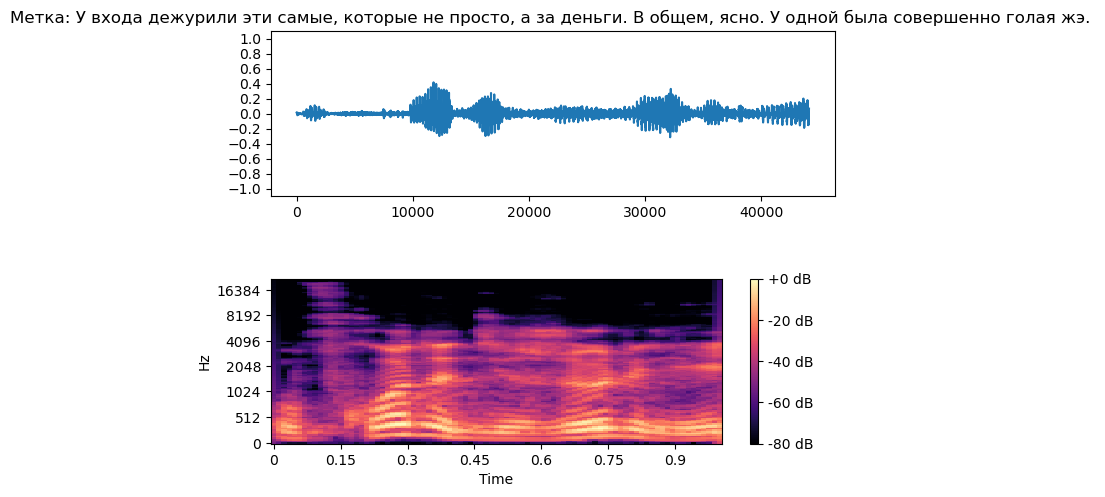

Audio playback


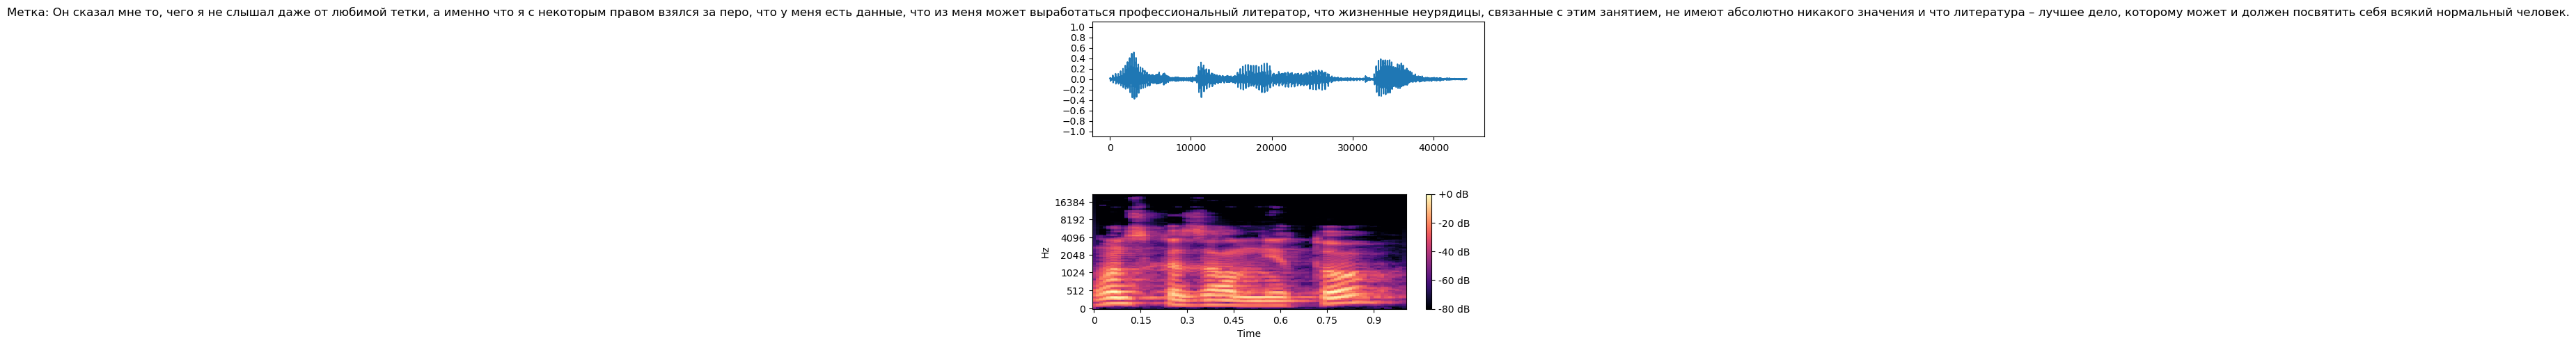

Audio playback


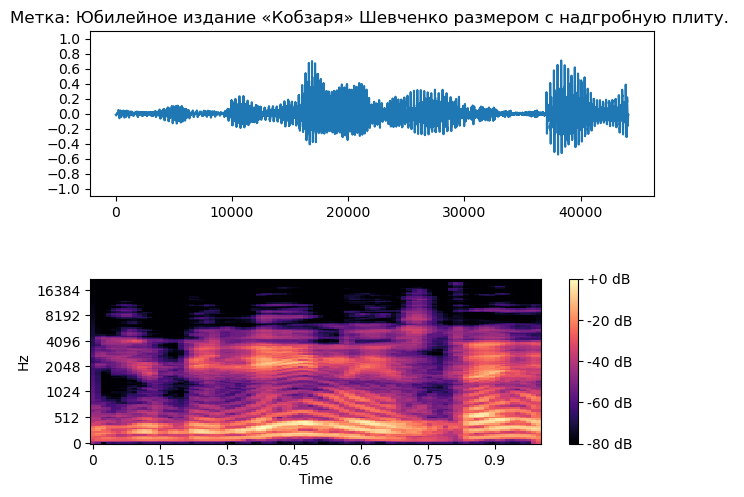

Audio playback


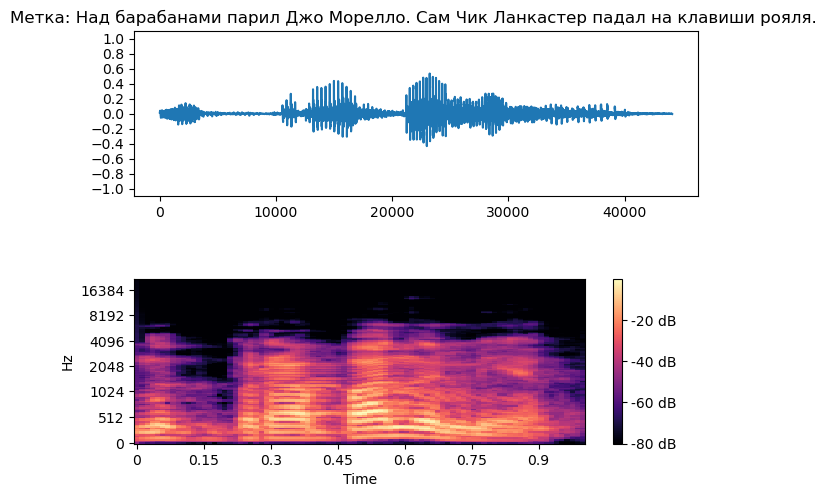

Audio playback


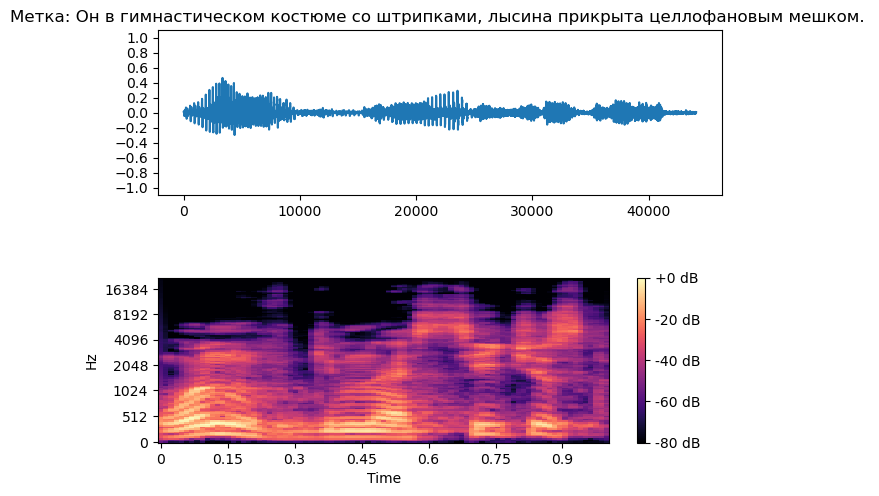

Audio playback


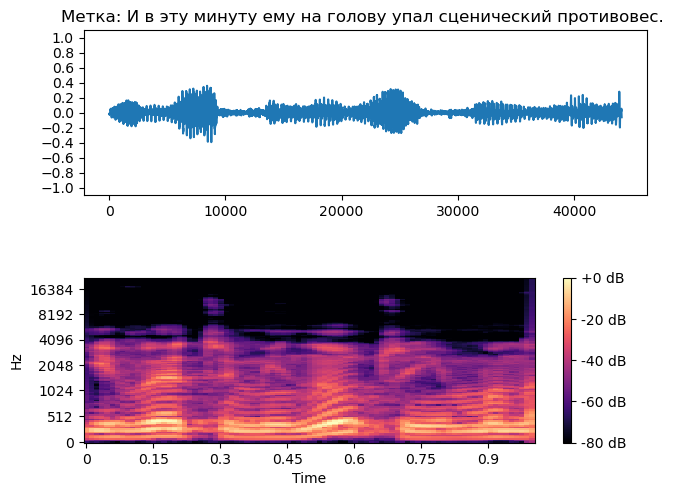

Audio playback


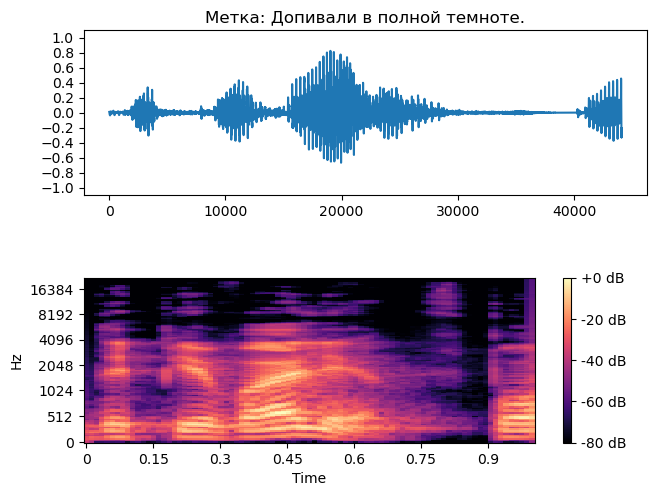

Audio playback


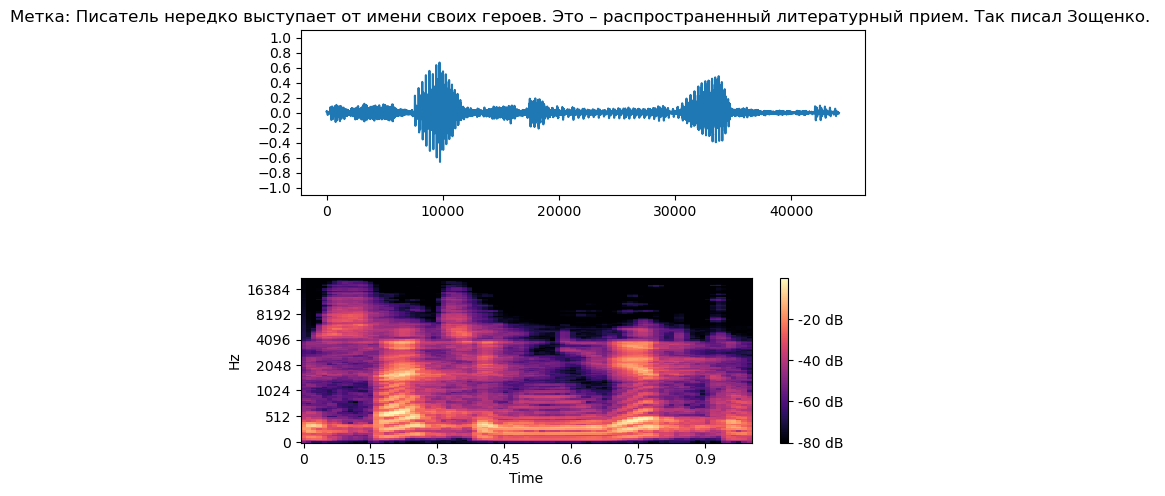

Audio playback


ValueError: num must be 1 <= num <= 10, not 11

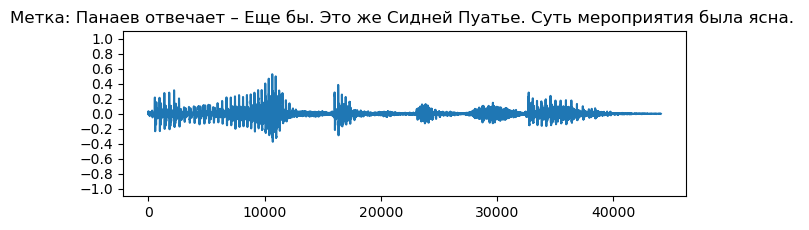

In [17]:
rows = 5
cols = 2

# Выбрать случайные индексы из батча
random_indices = random.sample(range(batch_size), rows * cols)

for i, index in enumerate(random_indices):
    plt.figure(figsize=(16, 15))
    
    # Расстояние между подграфиками по вертикали
    plt.subplots_adjust(hspace=0.5)
    
    # График аудиосигнала
    plt.subplot(rows, cols, i+1)
    audio_signal = audio[index].numpy()
    plt.plot(audio_signal)
    plt.title(f"Метка: {labels[index].numpy().decode('utf-8')}")
    plt.yticks(np.arange(-1.2, 1.2, 0.2))
    plt.ylim([-1.1, 1.1])

    # Спектрограмма
    plt.subplot(rows, cols, i+cols+1)
    audio_signal = audio[index].numpy()
    spectrogram = librosa.feature.melspectrogram(y=audio_signal, sr=CONST_LEN_OUTPUT_SEQUENCE)
    log_spectrogram = librosa.power_to_db(spectrogram, ref=np.max)
    librosa.display.specshow(log_spectrogram, sr=CONST_LEN_OUTPUT_SEQUENCE, x_axis='time', y_axis='mel')
    plt.colorbar(format='%+2.0f dB')
    
    plt.show()
    
    print('Audio playback')
    display.display(display.Audio(audio_signal, rate=CONST_LEN_OUTPUT_SEQUENCE))

## Обучение модели

In [64]:
EPOCHS = 10

In [65]:
# Определение количества уникальных классов в метках
number_of_classes = len(metadata['Text'].unique())

In [66]:
for spectrogram, _ in train_ds.take(1):
  input_shape = spectrogram.shape
print('Input shape:', input_shape)

Input shape: (64, 44100)


In [69]:
# Instantiate the `tf.keras.layers.Normalization` layer.
norm_layer = layers.Normalization()
# Fit the state of the layer to the spectrograms
# with `Normalization.adapt`.
norm_layer.adapt(data=train_ds.map(map_func=lambda spec, labels: spec), batch_size=None)

ValueError: in user code:

    File "/home/redalexdad/anaconda3/envs/dl_science/lib/python3.9/site-packages/keras/src/engine/base_preprocessing_layer.py", line 122, in adapt_step  *
        self._adapt_maybe_build(data)
    File "/home/redalexdad/anaconda3/envs/dl_science/lib/python3.9/site-packages/keras/src/engine/base_preprocessing_layer.py", line 284, in _adapt_maybe_build  **
        data_shape_nones = tuple([None] * len(data.shape))

    ValueError: Cannot take the length of shape with unknown rank.


In [58]:
model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=input_shape),
    # Downsample the input.
    tf.keras.layers.Resizing(32, 32),
    # Normalize.
    norm_layer,
    tf.keras.layers.Conv2D(32, 3, activation='relu'),
    tf.keras.layers.Conv2D(64, 3, activation='relu'),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Dropout(0.25),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(num_labels),
])

NameError: name 'norm_layer' is not defined

In [53]:
model.summary()

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_24 (Conv1D)          (None, 44098, 32)         128       
                                                                 
 max_pooling1d_24 (MaxPooli  (None, 22049, 32)         0         
 ng1D)                                                           
                                                                 
 conv1d_25 (Conv1D)          (None, 22047, 64)         6208      
                                                                 
 max_pooling1d_25 (MaxPooli  (None, 11023, 64)         0         
 ng1D)                                                           
                                                                 
 global_average_pooling1d_1  (None, 64)                0         
 2 (GlobalAveragePooling1D)                                      
                                                      

In [54]:
# Компиляция модели
model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

In [55]:
%%time
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS,
)

Epoch 1/10


ValueError: in user code:

    File "/home/redalexdad/anaconda3/envs/dl_science/lib/python3.9/site-packages/keras/src/engine/training.py", line 1401, in train_function  *
        return step_function(self, iterator)
    File "/home/redalexdad/anaconda3/envs/dl_science/lib/python3.9/site-packages/keras/src/engine/training.py", line 1384, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/home/redalexdad/anaconda3/envs/dl_science/lib/python3.9/site-packages/keras/src/engine/training.py", line 1373, in run_step  **
        outputs = model.train_step(data)
    File "/home/redalexdad/anaconda3/envs/dl_science/lib/python3.9/site-packages/keras/src/engine/training.py", line 1155, in train_step
        return self.compute_metrics(x, y, y_pred, sample_weight)
    File "/home/redalexdad/anaconda3/envs/dl_science/lib/python3.9/site-packages/keras/src/engine/training.py", line 1249, in compute_metrics
        self.compiled_metrics.update_state(y, y_pred, sample_weight)
    File "/home/redalexdad/anaconda3/envs/dl_science/lib/python3.9/site-packages/keras/src/engine/compile_utils.py", line 592, in update_state
        self.build(y_pred, y_true)
    File "/home/redalexdad/anaconda3/envs/dl_science/lib/python3.9/site-packages/keras/src/engine/compile_utils.py", line 498, in build
        self._metrics = tf.__internal__.nest.map_structure_up_to(
    File "/home/redalexdad/anaconda3/envs/dl_science/lib/python3.9/site-packages/keras/src/engine/compile_utils.py", line 646, in _get_metric_objects
        return [self._get_metric_object(m, y_t, y_p) for m in metrics]
    File "/home/redalexdad/anaconda3/envs/dl_science/lib/python3.9/site-packages/keras/src/engine/compile_utils.py", line 646, in <listcomp>
        return [self._get_metric_object(m, y_t, y_p) for m in metrics]
    File "/home/redalexdad/anaconda3/envs/dl_science/lib/python3.9/site-packages/keras/src/engine/compile_utils.py", line 667, in _get_metric_object
        y_t_rank = len(y_t.shape.as_list())

    ValueError: as_list() is not defined on an unknown TensorShape.


Text(0, 0.5, 'Accuracy [%]')

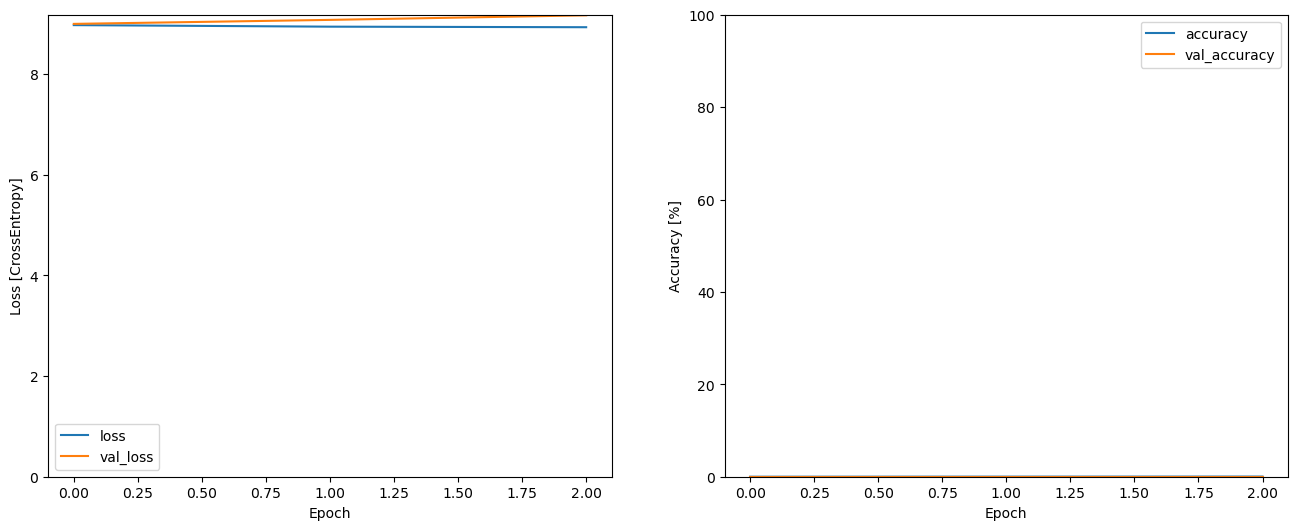

In [32]:
metrics = history.history

plt.figure(figsize=(16,6))
plt.subplot(1,2,1)
plt.plot(history.epoch, metrics['loss'], metrics['val_loss'])
plt.legend(['loss', 'val_loss'])
plt.ylim([0, max(plt.ylim())])
plt.xlabel('Epoch')
plt.ylabel('Loss [CrossEntropy]')

plt.subplot(1,2,2)
plt.plot(history.epoch, 100*np.array(metrics['accuracy']), 100*np.array(metrics['val_accuracy']))
plt.legend(['accuracy', 'val_accuracy'])
plt.ylim([0, 100])
plt.xlabel('Epoch')
plt.ylabel('Accuracy [%]')